# CS446/546 - Class Session 19 - Correlation networks

In this class session we are going to analyze gene expression data from a human bladder cancer cohort. We will load a data matrix of expression measurements of 4,473 genes in 414 different bladder cancer samples. These genes have been selected because they are differentially expressed between normal bladder and bladder cancer (thus more likely to have a function in bladder cancer specifically), but the columns in the data matrix are restricted to bladder cancer samples (not normal bladder) because we want to obtain a network representing variation across cancers. The measurements in the matrix have already been normalized to account for inter-sample heterogeneity and then log2 transformed. Our job is to compute Pearson correlation coefficients between all pairs of genes, obtain Fisher-transformed *z*-scores for all pairs of genes, test each pair of genes for significance of the z score, adjust for multiple hypothesis testing, filter to eliminate any pair for which *R* < 0.75 or *P*adj > 0.01, load the graph into an `igraph::Graph`, and plot the degree distribution on log-log scale. We will then answer two questions: (1) does the network look to be scale-free? and (2) what is it's best-fit scaling exponent?

Let's start by loading the packages that we will need for this notebook. Note the difference in language-design philosophy between R (which requires one package for this analysis) and python (where we have to load eight modules). Python keeps its core minimal, whereas R has a lot of statistical and plotting functions in the base language (or in packages that are loaded by default).

In [4]:
suppressPackageStartupMessages(
    library(igraph)
)

Read the tab-deliminted text file of gene expression measurements (rows correspond to genes, columns correspond to bladder tumor samples). (use `read.table` with `row.names=1`). As always, sanity check that the file that you loaded has the expected dimensions (4,473 x 414)

In [5]:
gene_matrix_for_network <- read.table("shared/bladder_cancer_genes_tcga.txt",
                                     sep="\t",
                                     header=TRUE,
                                     row.names=1,
                                     stringsAsFactors=FALSE)
dim(gene_matrix_for_network)

[1] 4473  414

Look up the online help for the `cor(x)` function, using the command `?cor`. When the `x` argument is a matrix, does `cor` compute the correlation coefficient of pairs of columns or pairs of rows?

In [6]:
?cor

Since `cor(x)` computes the correlation coefficients of pairs of *columns* of its matrix argument but we want to compute correlation coefficients of pairs of *genes* (and recall that genes are *rows* in our matrix `gene_matrix_for_network`), use the `t` function to transpose the matrix. Then use the `cor` function to compute the 4,473 x 4,473 matrix of gene-gene Pearson correlation coefficients, and call this matrix `gene_matrix_for_network_cor`. It is in your interest to do this as a one-line command (by composing the function calls), so we store only one big matrix in the environment:

In [7]:
gene_matrix_for_network_cor <- cor(t(gene_matrix_for_network))

Look up the online help for the `upper.tri` function. Does it return the matrix's upper triangle entries or the *index values* of the upper triangle entries of the matrix?

In [8]:
?upper.tri

Set the upper-triangle of the matrix `gene_matrix_for_network_cor` to zero, using (from left to right) three things: array indexing `[`, the function `upper.tri`, and the assignment operator `<-`. In the call to `upper.tri`, specify `diag=TRUE` to also zero out the diagonal.

In [9]:
gene_matrix_for_network_cor[upper.tri(gene_matrix_for_network_cor, diag=TRUE)] <- 0

Use the function `which` in order to obtain a vector `inds_correl_above_thresh` containing the indices of the entries of the matrix `gene_matrix_for_network_cor` for which *R* >= 0.75. Use array indexing to obtain the *R* values for these matrix entries, as a numpy array `cor_coeff_values_above_thresh`.

In [10]:
inds_correl_above_thresh <- which(gene_matrix_for_network_cor >= 0.75)
cor_coeff_values_above_thresh <- gene_matrix_for_network_cor[inds_correl_above_thresh]

Refer to Eq. (13.5) in the assigned readding for today's class (p9 of the PDF).  Obtain a vector of the correlation coefficients that exceeded 0.75, and Fisher-transform the correlation coefficient values to get a vector `z_scores` of *z* scores. Each of these *z* scores will correspond to an **edge** in the network, unless the absolute *z* score is too small such that we can't exclude the null hypothesis that the corresponding two genes' expression values are indepdenent (we will perform that check in the next step).

In [11]:
z_scores <- 0.5*log((1+gene_matrix_for_network_cor[inds_correl_above_thresh])/
                    (1-gene_matrix_for_network_cor[inds_correl_above_thresh]))

Delete the correlation matrix object in order to save memory (we won't need it from here on out).

In [12]:
rm(gene_matrix_for_network_cor)

Now we are going to perform a statistical test on *each* correlation coefficient that was >= 0.75.  Assume that under the null hypothesis that two genes are independent, then sqrt(M-3)z for the pair of genes is independent sample from the normal distribution with zero mean and unit variance, where M is the number of samples used to compute the Pearson correlation coefficient (i.e., M = 414). For each entry in `z_scores` compute a P value as the area under two tails of the normal distribution N(x),  where the two tails are x < -sqrt(M-3)z and x > sqrt(M-3)z. (You'll know you are doing it right if z=0 means you get a P value of 1).  You will want to use the functions `sqrt` and `pnorm`.

In [13]:
M <- ncol(gene_matrix_for_network)
P_values <- 2*(pnorm(-z_scores*sqrt(M-3)))

Look up the function `p.adjust` in the online help

In [14]:
?p.adjust

Adjust the P values for multiple hypothesis testing, using the `p.adjust` function with `method="hochberg"`

In [15]:
P_values_adj <- p.adjust(P_values, method="hochberg")

Verify that we don't need to drop any entries due to the adjusted P value not being small enough (use `which` and `length`); this should produce zero since we have M=414 samples per gene.

In [16]:
length(which(P_values_adj > 0.01))

[1] 0

Make an undirected graph from the row/column indices of the (upper-triangle) gene pairs whose  correlations were above our threshold (you'll want to use the `arrayInd`, `cbind`, and `graph_from_data_frame` functions for this). Print a summary of the network, as a sanity check. Make sure to specify `directed=FALSE` when you construct the graph.

In [17]:
N <- nrow(gene_matrix_for_network)
final_network <- graph_from_data_frame(cbind(arrayInd(inds_correl_above_thresh, 
                                                      .dim=c(N,N))), directed=FALSE)
summary(final_network)

IGRAPH b11fcc8 UN-- 1394 9916 -- 
+ attr: name (v/c)


Plot the degree distribution on log-log scale; does it appear to be scale-free?

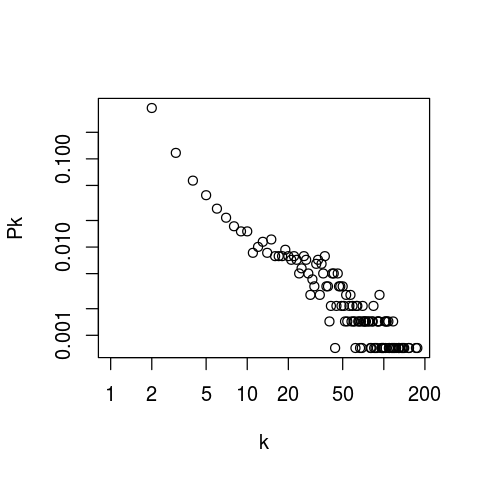

In [18]:
suppressWarnings(
    plot(degree.distribution(final_network), log="xy", xlab="k", ylab="Pk")
)

Use the `igraph::power.law.fit` function to estimate the scaling exponent *alpha* of the degree distribution:

In [19]:
power.law.fit(degree(final_network))$alpha

[1] 2.745358

## extra challenge:
If you got this far, see if you can scatter plot the relationship between R (as the independent variable) and -log10(P) value (as the dependent variable).  When the effect size variable (e.g., *R*) can range from negative to positive, this plot is sometimes called a "volcano plot".

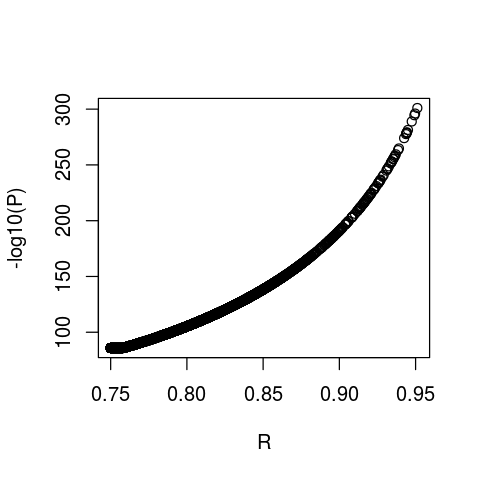

In [20]:
inds_use = which(P_values_adj > 0)
plot(cor_coeff_values_above_thresh[inds_use], -log10(P_values_adj[inds_use]), xlab="R", ylab="-log10(P)")

## extra-extra challenge
For each of the gene pairs for which R>0.75, see if you can compute the t-test P value for each correlation coefficient (don't bother adjusting for false discovery rate control).  Compare to the (un-adjusted) P values that you got using the Fisher transformation, using a scatter plot.  How do they compare?  Which test has better statistical power, for this case where M = 414? (If you are wondering, *general* advice is to use Fisher if M>=10; for very small numbers of samples, use the Student t test).

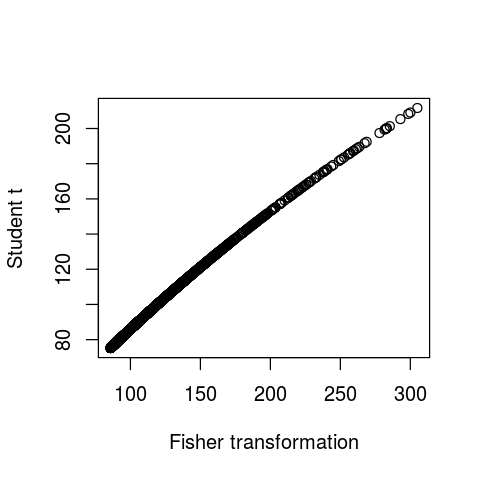

In [21]:
ts = cor_coeff_values_above_thresh * sqrt(M-2) / sqrt((1 - cor_coeff_values_above_thresh^2))
P_values_studentT = 2*pt(-ts, M-2)
inds_use = which(P_values > 0 & P_values_studentT > 0)
plot(-log10(P_values[inds_use]), -log10(P_values_studentT[inds_use]), xlab="Fisher transformation", ylab="Student t")